In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from matplotlib.colors import Normalize

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# in the interest of code readability, grids are not flattened

In [2]:
#  https://github.com/zhevnerchuk/XY-model-Metropolis-Simulation/blob/master/xy.py

In [3]:
def animate(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=None)):
    '''
    
    '''
    grid = rs.rand(*(L,L))
    H_mtx = init_H_matrix(grid, J)
    H = np.sum(H_mtx)/2
    H_vals = [H]
    
    f, ax = plt.subplots(1,1)
    f.set_size_inches(10,8)
    ax.set_xlim(-1,L)
    ax.set_ylim(-1,L)

    X = np.array([[x for x in range(L)] for x in range(L)])
    Y = np.array([[y for x in range(L)] for y in range(L)])
    U = np.cos(2*np.pi*grid)
    V = np.sin(2*np.pi*grid)

    colors = []
    [colors.append(np.abs(H_mtx[i,j])) for i,j in zip(range(L), range(L))]

    Q = ax.quiver(X, Y, U, V, colors, units='inches')

    ani = animation.FuncAnimation(f, update_anim, frames=nsteps, 
                                  fargs=(Q, nper_step, grid, J, H_mtx, H, T, rs), interval=10)

    ani.save(title, codec="libx264")


def get_delta_H(grid, J, change_pos, new_val):
    '''
    the delta_H between the old grid configuration and the proposed new
    grid configuration is computed and returned.
    
    method:
    (1) look at the 4 neighboring points of the chosen changing spin
        site
    (2) at each site, evaluate the hamiltonian difference from the random
        new_val and then subtract off the hamiltonian difference from the
        original old_val
    (3) add up each of the 4 terms obtained from (2)
    (4) return the negative of (3) (and multiply the term by -J if that 
        wasn't done in step (2)). this is the delta_H returned.
    
    args:
    - grid is the lattice
    - J is the coupling strength
    - change_pos is the randomly chosen position on the lattice grid at
      which the spin would be changing
    - new_val is the new spin value to which the spin would be changing
      to
      
    returns:
    - delta_H
    - a dictionary with {key: value} entries of 
      {neighboring position coords: corresponding component of delta_H}
      (useful for update_H_matrix)
    '''
    delta_H_dict = {}
    
    L = grid.shape[0]
    old_val = grid[change_pos]
    pos_list = list(change_pos)
    
    for i in range(len(change_pos)):
        pos_list[i] = (pos_list[i]+1) % L 
        delta_H_dict[tuple(pos_list)] = \
                (np.cos(2*np.pi * (grid[tuple(pos_list)] - new_val)) 
                 - np.cos(2*np.pi * (grid[tuple(pos_list)] - old_val)))

        pos_list[i] = (pos_list[i]-2) % L
        delta_H_dict[tuple(pos_list)] = \
                (np.cos(2 * np.pi * (grid[tuple(pos_list)] - new_val)) 
                 - np.cos(2 * np.pi * (grid[tuple(pos_list)] - old_val)))

        pos_list[i] = (pos_list[i]+1) % L

    delta_H = np.sum(delta_H_dict.values())
    return -J * delta_H, delta_H_dict


def init_H_matrix(grid, J):
    '''
    creates and returns the initial hamiltonian matrix of the grid
    for simplicity, only works with a LxL 2D grid
    '''
    H_mtx = np.zeros(grid.shape)
    L = grid.shape[0]
    
    for i in range(L):
        for j in range(L): 
            H_mtx[i,j] = 0
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[(i+1)%L,j]))
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[(i-1)%L,j]))
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[i,(j+1)%L]))
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[i,(j-1)%L]))
        
    return J*H_mtx


def step(grid, J, H_mtx, H, T, rs, return_vals=False):
    '''
    steps through each iteration of the updating XY grid
    
    - change_pos is the lattice site chosen at random
    - new_val is the new spin value for the chosen change_pos site
    - the changing is accepted with probability exp(-delta_H/T)
      where delta_H is the change in the Hamiltonian from the original
      to the proposed new spin at the site
      
    if return_vals=True, returns grid,H_mtx (for the run_XY function where
    the grid evolution is not animated)
    '''
    change_pos = tuple([rs.randint(z) for z in grid.shape])
    new_val = rs.rand()
    delta_H, delta_H_dict = get_delta_H(grid, J, change_pos, new_val)
    
    if ((delta_H <= 0) or 
        ((delta_H > 0) and (rs.rand() < np.exp(-delta_H / T)))):
        H_mtx = update_H_matrix(H_mtx, J, delta_H_dict, change_pos)
        grid[change_pos] = new_val
        H += delta_H / 2.0

    if return_vals:
        return grid, H_mtx, H


def update_anim(framenum, Q, nsteps, grid, J, H_mtx, H, T, rs, colored=True):
    '''
    updates the grid with the quiver arrows pivoting in the direction of their spin
    the colors represent 
    
    helper function for animation.FuncAnimation
    '''    
    for n in range(nsteps):
        grid, H_mtx, _ = step(grid, J, H_mtx, H, T, rs, return_vals=True)
    
    U = np.cos(2*np.pi*grid)
    V = np.sin(2*np.pi*grid)
    colors = np.abs(H_mtx.flatten('F'))
    
    if colored:
        Q.set_UVC(U,V,colors)
    else:
        Q.set_UVC(U,V)
    
    return Q,


def update_H_matrix(H_mtx, J, delta_H_dict, change_pos):
    '''
    updates and returns the H_mtx depending on values from
    the get_delta_H() function
    
    method:
    (1) iterates through the keys (positions of the neighbors) and 
        values (components of delta_H change) in delta_H_dict
    (2) for each iteration, subtracts off the delta_H component from
        the neighbor as well as the change_pos position itself
    (3) returns the result
    
    args:
    - H_mtx is the hamiltonian matrix
    - J is the coupling strength
    - delta_H_dict is a dictionary returned from the fn get_delta_H()
    - change_pos is the randomly chosen position on the lattice grid at
      which the spin is changing
      
    returns:
    - the new updated hamiltonian matrix
    '''    
    for key in delta_H_dict.iterkeys():
        H_mtx[key] -= delta_H_dict[key]*J
        H_mtx[change_pos] -= delta_H_dict[key]*J
        
    return H_mtx


    
def run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=None), colored=True):
    '''
    
    '''
    grid = rs.rand(*(L,L))
    H_mtx = init_H_matrix(grid, J)
    H = np.sum(H_mtx)/2
    H_vals = [H]
    
    f, ax = plt.subplots(1,1)
    f.set_size_inches(10,8)
    ax.set_xlim(-1,L)
    ax.set_ylim(-1,L)

    X = np.array([[x for x in range(L)] for x in range(L)])
    Y = np.array([[y for x in range(L)] for y in range(L)])
    U = np.cos(2*np.pi*grid)
    V = np.sin(2*np.pi*grid)

    if colored==True:
        colors = []
        [colors.append(np.abs(H_mtx[i,j])) for i,j in zip(range(L), range(L))]
        Q = ax.quiver(X, Y, U, V, colors, units='inches')
    elif colored=='Map':
        colors = V/np.sqrt(U**2+V**2) # np.sin(np.arctan2(V,U))
#         norm = Normalize()
#         norm.autoscale(colors)
#         colormap = cm.coolwarm
    
#         sm = cm.ScalarMappable(cmap=colormap, norm=norm)
#         sm.set_array([])

#         plt.colorbar(sm)
        
#         Q = ax.quiver(X, Y, U, V, colormap(colors), units='inches', cmap=colormap)
        Q = plt.quiver(X, Y, U, V, colors, cmap=cm.coolwarm)
        plt.colorbar()
#         raise Exception
    else:
        Q = ax.quiver(X, Y, U, V, units='inches')
    
    for framenum in range(nsteps+1):
        Q, = update_anim(framenum, Q, nper_step, grid, J, H_mtx, H, T, rs, colored=colored)

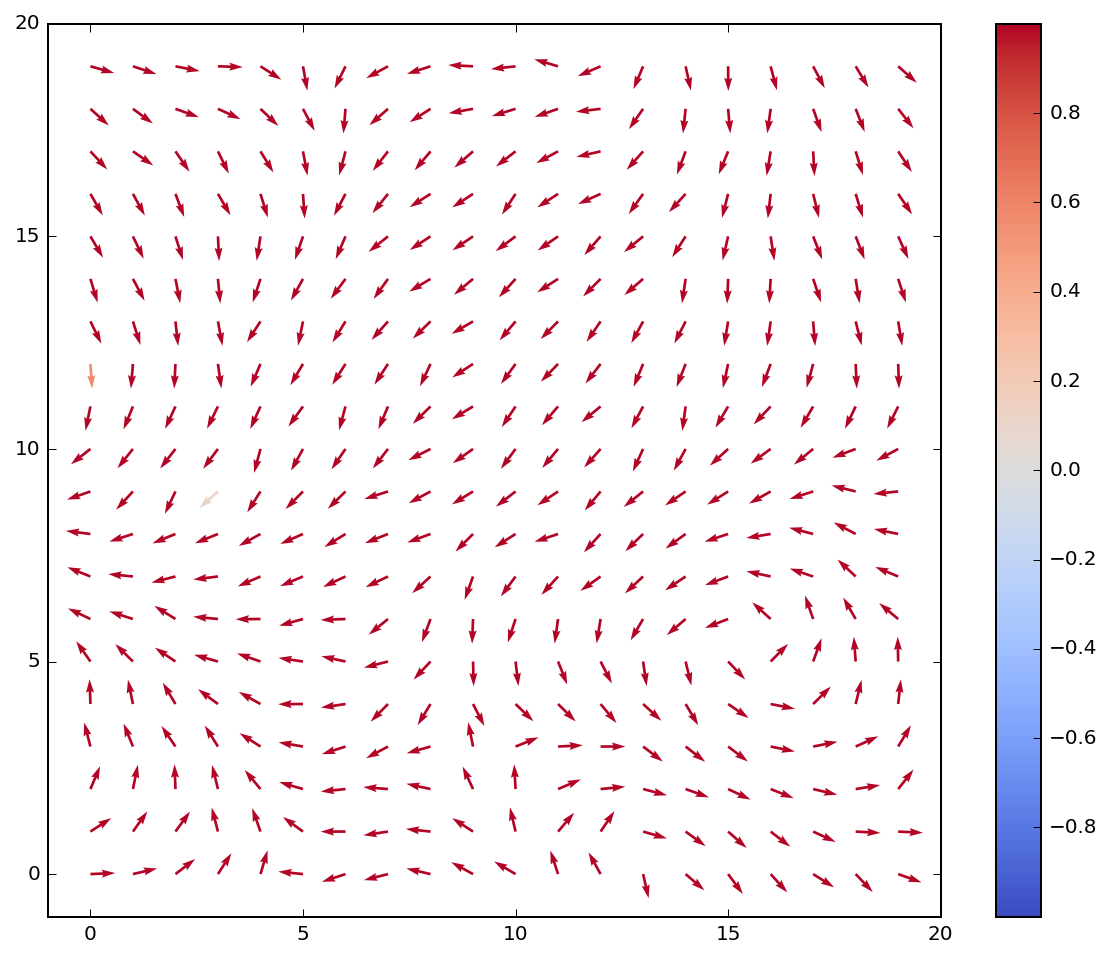

In [262]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 500
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675), colored='Map')

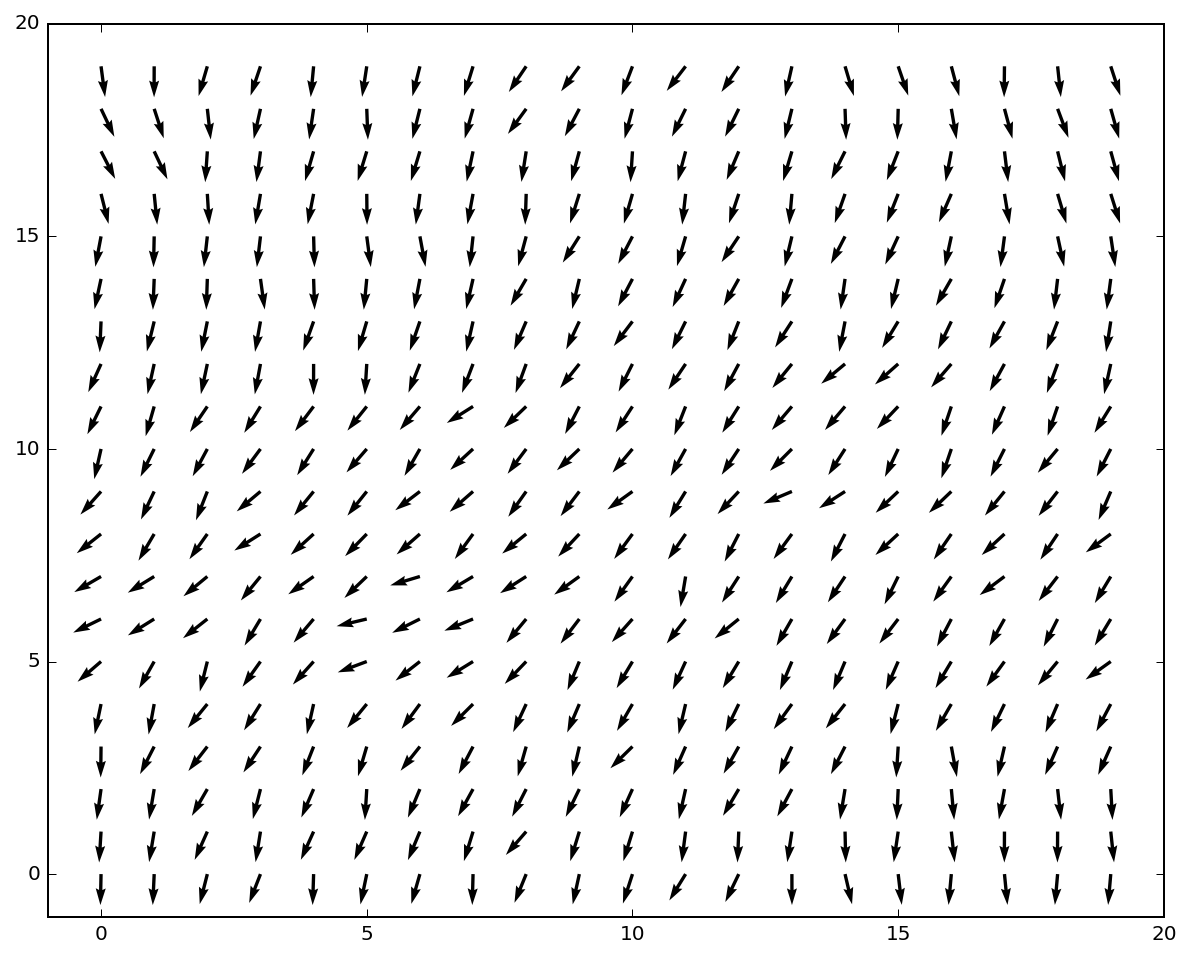

In [11]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 3000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675), colored=False)

In [4]:
def get_specific_heat(H_vals, T, N):
    actual_vals = int(len(H_vals) / 10.0)
#     return np.var(H_vals[-actual_vals:]) * ((1.0/T) ** 2)
#     return np.var(H_vals[-actual_vals:]) * (1.0/(T**2 * N))
    return np.var(H_vals) * (1.0/(T**2 * N))


def simulate(nsteps, nper_step, grid, J, H_mtx, H, T, rs, H_vals):
    for i in range(nsteps):
        for j in range(nper_step):
            grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)
        H_vals.append(H)
    return H_vals

In [12]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 500
nper_step = 100


max_T = 4.0 #.4
min_T = 0.1 #0.01

T_vals = np.linspace(min_T, max_T, L*L)
specific_heats = []

rs=np.random.RandomState(seed=7675)
grid = rs.rand(*(L,L))
H_mtx = init_H_matrix(grid, J)
H = np.sum(H_mtx)/2
H_vals= [H]

for T in T_vals:
    H_vals = simulate(nsteps, nper_step, grid, 1, H_mtx, H, T, rs, H_vals)
    specific_heats.append(get_specific_heat(H_vals, T, L*L))

specific_heats = np.array(specific_heats)

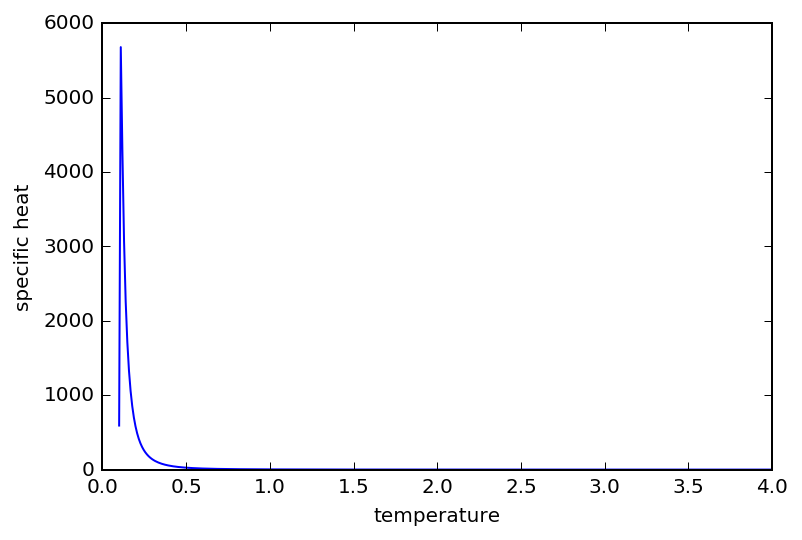

In [13]:
# T = [0.1, 4.0]
plt.plot(T_vals, specific_heats)
plt.xlabel('temperature')
plt.ylabel('specific heat')
plt.show()



In [15]:
T_vals[np.argmax(specific_heats)]

0.10977443609022557

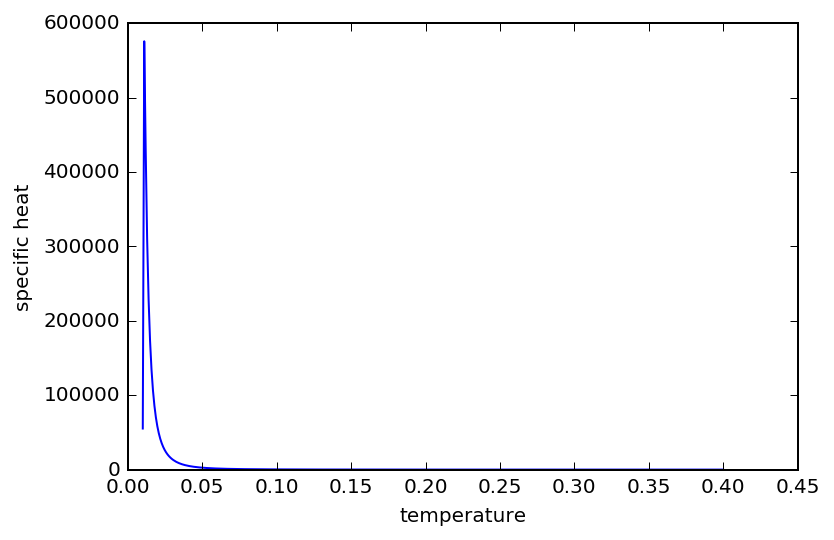

In [7]:
# T = [0.01, 0.4]
plt.plot(T_vals, specific_heats)
plt.xlabel('temperature')
plt.ylabel('specific heat')
# plt.axvline(T_vals[np.argmax(specific_heats), 0], color='b', linestyle='dashed', linewidth=2)
plt.show()



In [9]:
T_vals[np.argmax(specific_heats)]

0.010977443609022556

In [157]:
# specific_heats[8]
print 'T_c?:', T_vals[8], '//', T_vals[np.where(specific_heats>17)[0][0]]

T_c?: 0.0178195488722 // 0.0334586466165


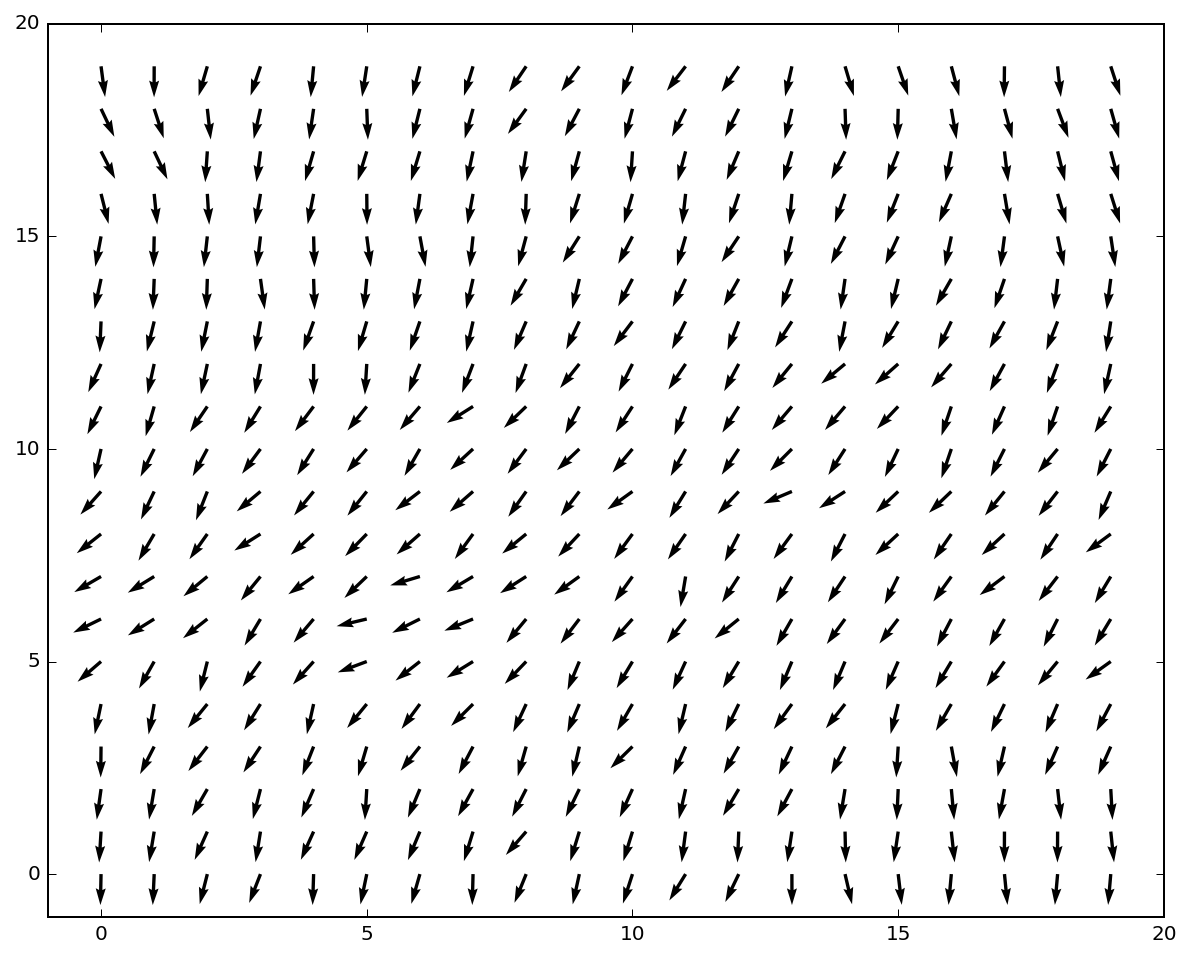

In [158]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 3000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675), colored=False)

In [ ]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 3000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675), colored=False)

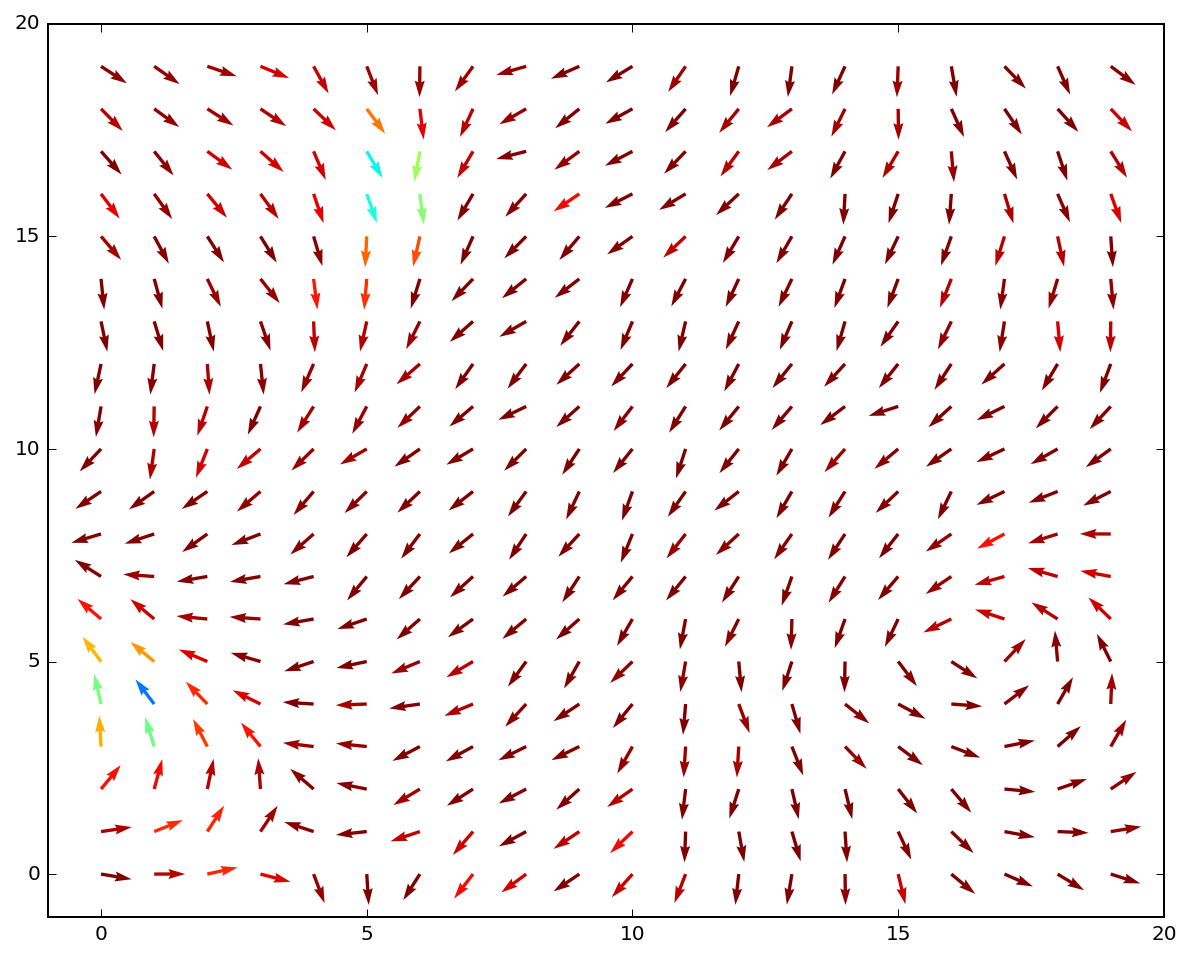

In [114]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 1000
nper_step = 100
title = 'playing_around_6A.mp4'

animate(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675))

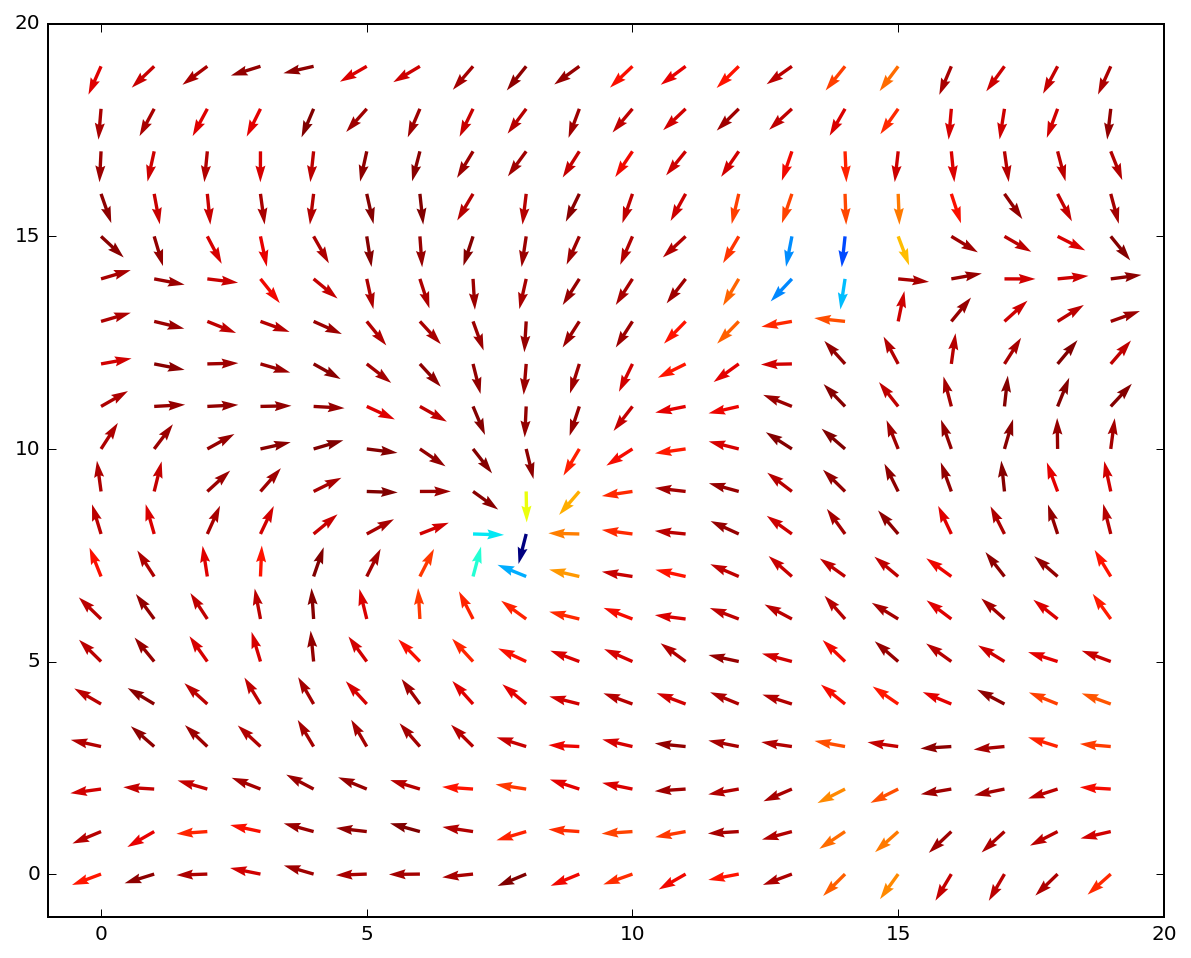

In [281]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 1000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=658976), colored=True)

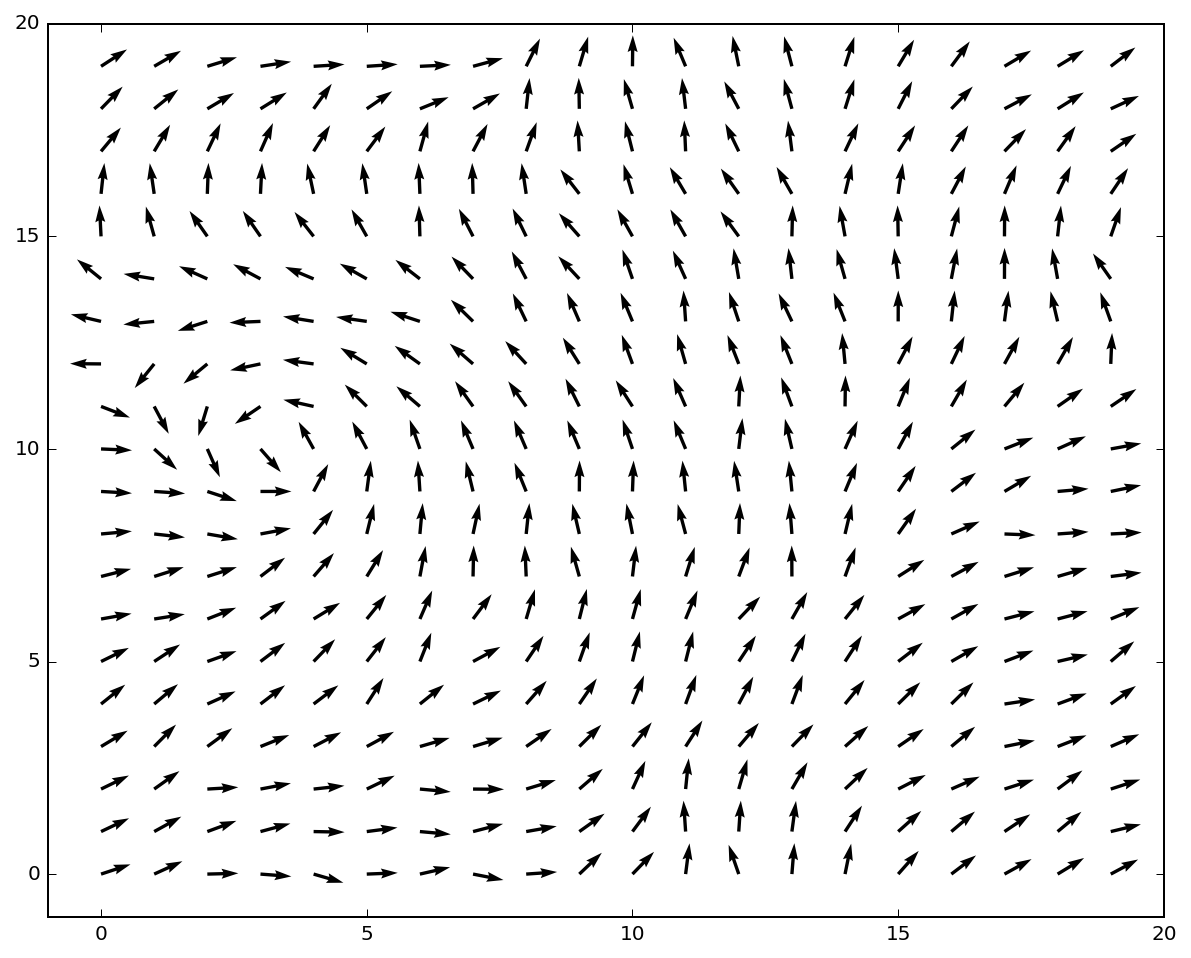

In [274]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 1000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=30), colored=False)

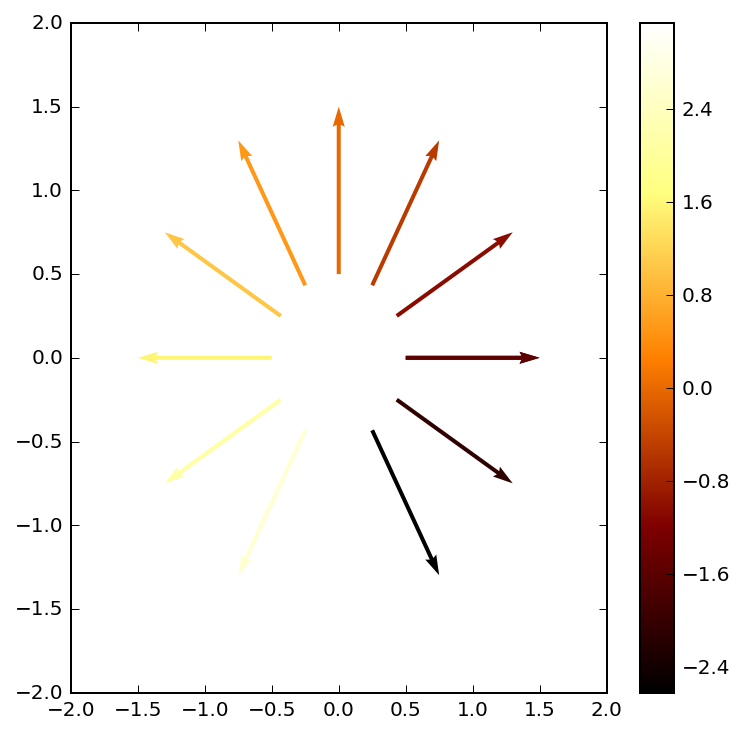

In [271]:
ph = np.linspace(0, 2*np.pi, 13)
x = np.cos(ph)
y = np.sin(ph)
u = np.cos(ph)
v = np.sin(ph)
colors = -np.arctan2(u, v)

plt.figure(figsize=(6, 6))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.quiver(x, y, u, v, colors,  angles='xy', 
           scale_units='xy', scale=1, pivot='mid', cmap='aa')
plt.colorbar()
plt.show()

In [282]:
plt.register_cmap(name='aa', data=cdict)
cdict = {'red':   ((0.0,  0.0, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'green': ((0.0,  0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0,  1.0, 1.0)),

         'blue':  ((0.0,  0.0, 0.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  1.0, 1.0))}